$Saroj\ Sathish - ssathish$

$Suryanarayanan\ Balaji - suryanab$

In [1]:
import findspark
findspark.init()
findspark.find()

import pyspark
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("MQTT_dataset_IOT") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/11/29 16:03:18 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/11/29 16:03:18 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/11/29 16:03:18 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/11/29 16:03:18 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


## Data Ingestion

In [2]:
from pyspark import SparkFiles

df2 = spark.read.csv( ("gs://dataproc-staging-us-west3-650974721448-eojcphee/test30_augmented.csv"),header=True, inferSchema= True)
df1 = spark.read.csv( ("gs://dataproc-staging-us-west3-650974721448-eojcphee/train70_augmented.csv"),header=True, inferSchema= True)

In [3]:
df1.select('target').distinct().collect()

[Row(target='slowite'),
 Row(target='bruteforce'),
 Row(target='flood'),
 Row(target='malformed'),
 Row(target='dos'),
 Row(target='legitimate')]

In [5]:
df3 = df1.limit(280000) ## Train dataset in ratio

df4 = df2.limit(120000)  ## Test dataset in ratio
df = df3.union(df4) ## combining both
df.printSchema()

root
 |-- tcp.flags: string (nullable = true)
 |-- tcp.time_delta: double (nullable = true)
 |-- tcp.len: integer (nullable = true)
 |-- mqtt.conack.flags: string (nullable = true)
 |-- mqtt.conack.flags.reserved: double (nullable = true)
 |-- mqtt.conack.flags.sp: double (nullable = true)
 |-- mqtt.conack.val: double (nullable = true)
 |-- mqtt.conflag.cleansess: double (nullable = true)
 |-- mqtt.conflag.passwd: double (nullable = true)
 |-- mqtt.conflag.qos: double (nullable = true)
 |-- mqtt.conflag.reserved: double (nullable = true)
 |-- mqtt.conflag.retain: double (nullable = true)
 |-- mqtt.conflag.uname: double (nullable = true)
 |-- mqtt.conflag.willflag: double (nullable = true)
 |-- mqtt.conflags: string (nullable = true)
 |-- mqtt.dupflag: double (nullable = true)
 |-- mqtt.hdrflags: string (nullable = true)
 |-- mqtt.kalive: double (nullable = true)
 |-- mqtt.len: double (nullable = true)
 |-- mqtt.msg: string (nullable = true)
 |-- mqtt.msgid: double (nullable = true)
 |-

Ingesting test and train to postgres table. Created a schmea of name "mqtt" in postgres before writing.

In [6]:
from pyspark.sql.functions import lit,length,mean

In [7]:
from pyspark.sql.functions import monotonically_increasing_id, when
dfn = df.withColumn("id",monotonically_increasing_id())

Created a new field "id" just for separating train and test. We could have added for train and test separtely before wrting into table. But doing this way for learning purpose.

In [8]:
dfnew = dfn.withColumn("Test_or_Train",when(dfn["id"]< 280000,lit(0)).otherwise(lit(1))) ## Separate Train with 0 and test1

In [9]:
dfupdated = dfnew.drop("id")  ## Drooping "id" which was used just for sepaating train and test data

In [10]:
for i in dfupdated.columns:
    dfupdated = dfupdated.withColumnRenamed(i,i.replace('.','_'))

In [11]:
dftrain = dfupdated.filter(dfupdated.Test_or_Train == 0)
dftrain.select(mean("mqtt_len")).show()

+------------------+
|     avg(mqtt_len)|
+------------------+
|12.229435714285714|
+------------------+



In [12]:
dfupdated.groupBy("target").mean("tcp_len").show(10)

+----------+------------------+
|    target|      avg(tcp_len)|
+----------+------------------+
|   slowite|3.6532035160238054|
|bruteforce|  3.26464370103221|
|     flood|13536.059673003992|
| malformed|22.138503259192916|
|       dos| 313.4333484756713|
|legitimate| 7.780891095544522|
+----------+------------------+



In [13]:
from pyspark.sql.functions import desc
def frequent(X):
    df1 = dfupdated.groupby("tcp_flags").count()
    return df1.sort(desc("count")).show(X)

In [14]:
print("Enter x in most frequent X TCP_Flags to be dsiplayed ")
Y = input()
X = int(Y)
frequent(X)

Enter x in most frequent X TCP_Flags to be dsiplayed 


 4


+----------+------+
| tcp_flags| count|
+----------+------+
|0x00000018|198039|
|0x00000010|155806|
|0x00000012| 12651|
|0x00000011| 12429|
+----------+------+
only showing top 4 rows



In [15]:
Target = dfupdated.select("target").distinct()
Target.show()

+----------+
|    target|
+----------+
|   slowite|
|bruteforce|
|     flood|
| malformed|
|       dos|
|legitimate|
+----------+



## Twitter Analytics

Based on the types of attacks, Twitter analytics were carried out to see what type of attack is the most common.

In [36]:
list_target = [x[0] for x in Target.select('target').collect()]
list_target

['slowite', 'bruteforce', 'flood', 'malformed', 'dos', 'legitimate']

In [43]:
appName = "Twitter Real-time Analytics via Kafka and Spark"
master = "local"
conf = pyspark.SparkConf().set('spark.driver.host','127.0.0.1').setAppName(appName).setMaster(master)
sc = SparkContext.getOrCreate(conf=conf)

spark = SparkSession.builder \
    .appName("Our Twitter Spark and Kafka") \
        .getOrCreate()

sc

<SparkContext master=local[*] appName=MQTT_dataset_IOT>

In [68]:
import tweepy
import time
import kafka
from kafka import KafkaProducer
import sys

bearer_token= "AAAAAAAAAAAAAAAAAAAAACl%2FigEAAAAA9%2F82vRNrR2MoWfmke4hRn4AnQoQ%3DokqYmiynZnJgsz2EU15PvtX9TjwNZ5tNKkABV0oTuUpuwSAXZx"
api_key = "YAbwCQ4IvFAkEdAx4Y4tFVsZr"
api_secret = "yx1DE4a7THcb68z2T0rBsVZuSHJP2soBAWKoXToxNhem0gFPdN"
access_token = '1572232364641718274-PgBjm0CC00CLmovbwQPnQUuRe6JJMU'
access_token_secret = '2QY0YfofpDwurttroC4eMhFR8hSnbj0rwN2NDARA33iGz'

tweepy.Client(bearer_token,api_key,api_secret,access_token,access_token_secret)
auth = tweepy.OAuth1UserHandler(api_key,api_secret,access_token,access_token_secret)
api = tweepy.API(auth)

search_terms = list_target


producer = KafkaProducer(bootstrap_servers='localhost:9092')
topic_name = "saru"

start = time.time() 
class MyStream(tweepy.StreamingClient):
    def on_connect(self):
        print("connected")
    
    def on_tweet(self,tweet):
        if tweet.referenced_tweets == None:
            end = time.time()
            if end > start + 300:
                sys.exit()
            else:
                print (tweet.text)
                producer.send(topic_name,tweet.text.encode('utf-8'))
                #time.sleep(0.1)
                   
stream = MyStream(bearer_token=bearer_token)


for term in search_terms:
    stream.add_rules(tweepy.StreamRule(term))

stream.filter(tweet_fields=["referenced_tweets"])

Stream encountered HTTP error: 503
HTTP error response text: {"title":"ConnectionException","detail":"Your subscription change is currently being provisioned, please try again in a minute.","connection_issue":"ProvisioningSubscription","type":"https://api.twitter.com/2/problems/streaming-connection"}


connected
adoro o canal dos trigêmeos sturniolos, uns queridos https://t.co/zNg7jXg8T1
no debí no debí decirle a mi mamá que era un set de dos álbumes
tô com sdd dos meus amigos
Saudade dos crentes querendo obrigar a gente a aceitar jesus, agora eles querem obrigar a aceitar o Diabo
Se que todos ya tienen a su favorito. Pero me agradería que salven a Juan, ahí se va unos de los otros dos simios y él del estrés abandona. Y abre la posibilidad de uno nuevo o que vuelva Tomas. Y se pone interesante #GH22
La paz mental que me dejaron dos mensajes hoy es impresionante
DoSんな頃すぞ
Ya no nos queda otra que tener paciencia. Hay que ganar como sea los dos próximos partidos. Fe, se nos está yendo todo a la mierda.
BORA SÃO PAULO BORA ATRÁS DOS 3 PONTOS EM CASA
Yo me quejo de los jugadores de lol pero no le digo a nadie que juego genshin hace mas de dos años TODOS LOS DIAS 🤠
Hay que hacer autocrítica, reconocer lo que está mal, dos años seguidos en Europa League, lo peor es que antes de tiempo te pi

SystemExit: 

C:\Users\SAROJ SATHISH\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [69]:
from kafka import KafkaConsumer
import json

topic_name = 'saru'

kafka_consumer = KafkaConsumer(
    topic_name,
    bootstrap_servers=['localhost:9092'],
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    auto_commit_interval_ms =  5000,
    fetch_max_bytes = 128,
    max_poll_records = 100,
    value_deserializer=lambda x: x.decode('utf-8'),
    consumer_timeout_ms=10000)

In [77]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F

data2 = None
i = 0

emp_RDD = spark.sparkContext.emptyRDD()
 
columns1 = StructType([StructField('target', StringType(), False),
                       StructField('count', IntegerType(), False)])
 
# Creating an empty DataFrame
result = spark.createDataFrame(data=emp_RDD,
                                         schema=columns1)
 

search_terms = list_target

for message in kafka_consumer:
    streamed_data = None
    i = i + 1
    if i > 150:
        break
    data = [message.value]
        
    tweet = spark.createDataFrame(data,"string")

    streamed_data = tweet.withColumn('target', explode(split(col('value'), ' '))) \
                    .groupBy('target') \
                    .count() \
                    .sort('count', ascending=False) \
                    .filter(F.col("target").isin(search_terms))
    
    result = result.union(streamed_data)
    
result.show(20,vertical = True)

ERROR:kafka.conn:Error sending request data to <BrokerConnection node_id=0 host=host.docker.internal:9092 <connected> [IPv4 ('10.0.0.129', 9092)]>
Traceback (most recent call last):
  File "C:\Users\SAROJ SATHISH\anaconda3\lib\site-packages\kafka\conn.py", line 1029, in send_pending_requests_v2
    total_bytes = self._send_bytes(self._send_buffer)
  File "C:\Users\SAROJ SATHISH\anaconda3\lib\site-packages\kafka\conn.py", line 582, in _send_bytes
    sent_bytes = self._sock.send(data[total_sent:])
ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine


-RECORD 0-----
 target | dos 
 count  | 1   
-RECORD 1-----
 target | dos 
 count  | 1   
-RECORD 2-----
 target | dos 
 count  | 1   
-RECORD 3-----
 target | dos 
 count  | 1   
-RECORD 4-----
 target | dos 
 count  | 1   
-RECORD 5-----
 target | dos 
 count  | 1   
-RECORD 6-----
 target | dos 
 count  | 1   
-RECORD 7-----
 target | dos 
 count  | 1   
-RECORD 8-----
 target | dos 
 count  | 1   
-RECORD 9-----
 target | dos 
 count  | 2   
-RECORD 10----
 target | dos 
 count  | 1   
-RECORD 11----
 target | dos 
 count  | 1   
-RECORD 12----
 target | dos 
 count  | 1   
-RECORD 13----
 target | dos 
 count  | 1   
-RECORD 14----
 target | dos 
 count  | 1   
-RECORD 15----
 target | dos 
 count  | 1   
-RECORD 16----
 target | dos 
 count  | 1   
-RECORD 17----
 target | dos 
 count  | 1   
-RECORD 18----
 target | dos 
 count  | 1   
-RECORD 19----
 target | dos 
 count  | 1   
only showing top 20 rows



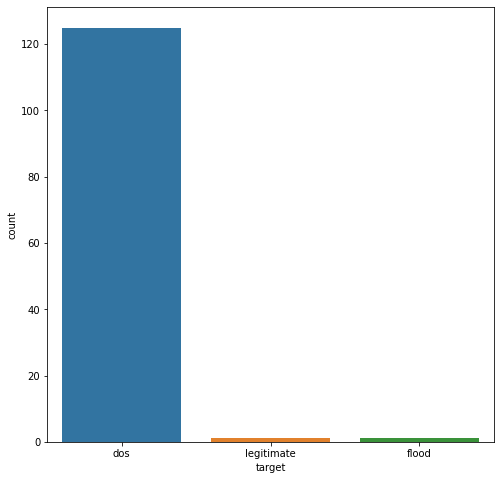

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
plt.figure( figsize = ( 8, 8 ) )

toplist= result.groupBy("target").count().sort("count",ascending=False).toPandas()
sns.barplot( x="target", y="count", data=toplist)
plt.show()

In [84]:
print("The most popular Target on Twitter is :")
toplist.iloc[0,:][0]

The most popular Target on Twitter is :


'dos'

## Data Engineering

### Checking NA values

In [26]:
from pyspark.sql.functions import *

null_counts_plays_df = dfupdated.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                        for c in dfupdated.columns])

null_counts_plays_df.show(truncate=False, vertical=True)

-RECORD 0-------------------------
 tcp_flags                  | 0   
 tcp_time_delta             | 0   
 tcp_len                    | 0   
 mqtt_conack_flags          | 0   
 mqtt_conack_flags_reserved | 0   
 mqtt_conack_flags_sp       | 0   
 mqtt_conack_val            | 0   
 mqtt_conflag_cleansess     | 0   
 mqtt_conflag_passwd        | 0   
 mqtt_conflag_qos           | 0   
 mqtt_conflag_reserved      | 0   
 mqtt_conflag_retain        | 0   
 mqtt_conflag_uname         | 0   
 mqtt_conflag_willflag      | 0   
 mqtt_conflags              | 0   
 mqtt_dupflag               | 0   
 mqtt_hdrflags              | 0   
 mqtt_kalive                | 0   
 mqtt_len                   | 0   
 mqtt_msg                   | 0   
 mqtt_msgid                 | 0   
 mqtt_msgtype               | 0   
 mqtt_proto_len             | 0   
 mqtt_protoname             | 0   
 mqtt_qos                   | 0   
 mqtt_retain                | 0   
 mqtt_sub_qos               | 0   
 mqtt_suback_qos    

This dataset has no null values present.

In [27]:
numeric_features = [feature[0] for feature in dfupdated.dtypes if feature[1] in ('int','double')]
numeric_features

['tcp_time_delta',
 'tcp_len',
 'mqtt_conack_flags_reserved',
 'mqtt_conack_flags_sp',
 'mqtt_conack_val',
 'mqtt_conflag_cleansess',
 'mqtt_conflag_passwd',
 'mqtt_conflag_qos',
 'mqtt_conflag_reserved',
 'mqtt_conflag_retain',
 'mqtt_conflag_uname',
 'mqtt_conflag_willflag',
 'mqtt_dupflag',
 'mqtt_kalive',
 'mqtt_len',
 'mqtt_msgid',
 'mqtt_msgtype',
 'mqtt_proto_len',
 'mqtt_qos',
 'mqtt_retain',
 'mqtt_sub_qos',
 'mqtt_suback_qos',
 'mqtt_ver',
 'mqtt_willmsg',
 'mqtt_willmsg_len',
 'mqtt_willtopic',
 'mqtt_willtopic_len',
 'Test_or_Train']

In [28]:
dfupdated.summary().show(truncate=False, vertical=True)

-RECORD 0----------------------------------------------
 summary                    | count                    
 tcp_flags                  | 400000                   
 tcp_time_delta             | 400000                   
 tcp_len                    | 400000                   
 mqtt_conack_flags          | 400000                   
 mqtt_conack_flags_reserved | 400000                   
 mqtt_conack_flags_sp       | 400000                   
 mqtt_conack_val            | 400000                   
 mqtt_conflag_cleansess     | 400000                   
 mqtt_conflag_passwd        | 400000                   
 mqtt_conflag_qos           | 400000                   
 mqtt_conflag_reserved      | 400000                   
 mqtt_conflag_retain        | 400000                   
 mqtt_conflag_uname         | 400000                   
 mqtt_conflag_willflag      | 400000                   
 mqtt_conflags              | 400000                   
 mqtt_dupflag               | 400000            

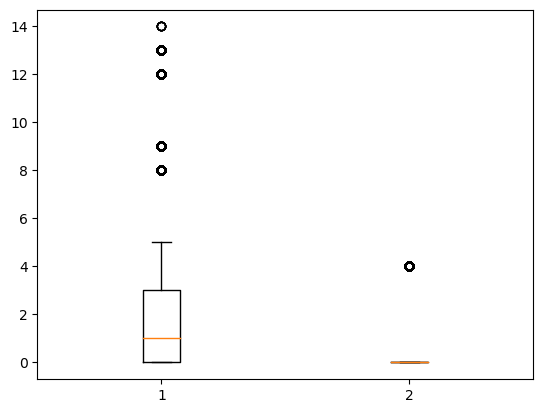

In [29]:
import matplotlib.pyplot as plt
spotted_data = dfupdated[numeric_features[16:18]].toPandas()
figure_subset = plt.boxplot(spotted_data)

A boxplot of the columns shows the column summary.

### Checking for Outliers

In [30]:
from functools import reduce

def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',reduce(column_add, ( df[col] for col in  selected_columns)))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [31]:
df_with_outlier_handling = find_outliers(dfupdated)
df_with_outlier_handling.show(1, vertical=True)

-RECORD 0--------------------------------
 tcp_flags                  | 0x00000018 
 tcp_time_delta             | 1.000039   
 tcp_len                    | 13         
 mqtt_conack_flags          | 0          
 mqtt_conack_flags_reserved | 0.0        
 mqtt_conack_flags_sp       | 0.0        
 mqtt_conack_val            | 0.0        
 mqtt_conflag_cleansess     | 0.0        
 mqtt_conflag_passwd        | 0.0        
 mqtt_conflag_qos           | 0.0        
 mqtt_conflag_reserved      | 0.0        
 mqtt_conflag_retain        | 0.0        
 mqtt_conflag_uname         | 0.0        
 mqtt_conflag_willflag      | 0.0        
 mqtt_conflags              | 0          
 mqtt_dupflag               | 0.0        
 mqtt_hdrflags              | 0x00000030 
 mqtt_kalive                | 0.0        
 mqtt_len                   | 11.0       
 mqtt_msg                   | 32         
 mqtt_msgid                 | 0.0        
 mqtt_msgtype               | 3.0        
 mqtt_proto_len             | 0.0 

In [32]:
df_with_outlier_handling.groupby("total_outliers").count().show()

+--------------+------+
|total_outliers| count|
+--------------+------+
|             1| 39200|
|             0|360800|
+--------------+------+



In [33]:
df_with_substituted_na_and_outliers = df_with_outlier_handling.\
        filter(df_with_outlier_handling['total_Outliers']<=2)
print(df_with_substituted_na_and_outliers.count())

400000


After the null values are taken care of, the outliers present in the columns need to be handled. Upon checking, it was found that all the columns had less than two outliers, so none of them were dropped.

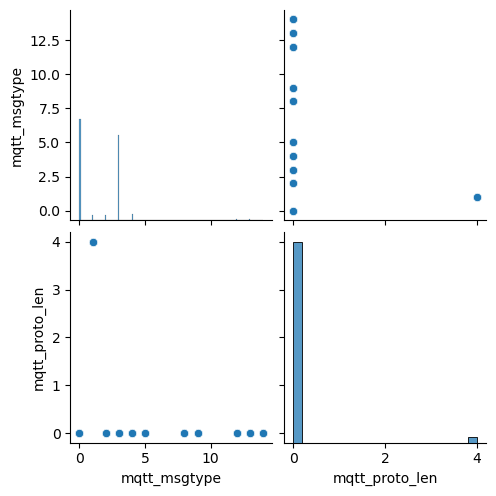

In [36]:
import seaborn as sns

sns.pairplot(spotted_data)

### Accounting for highly correlated columns

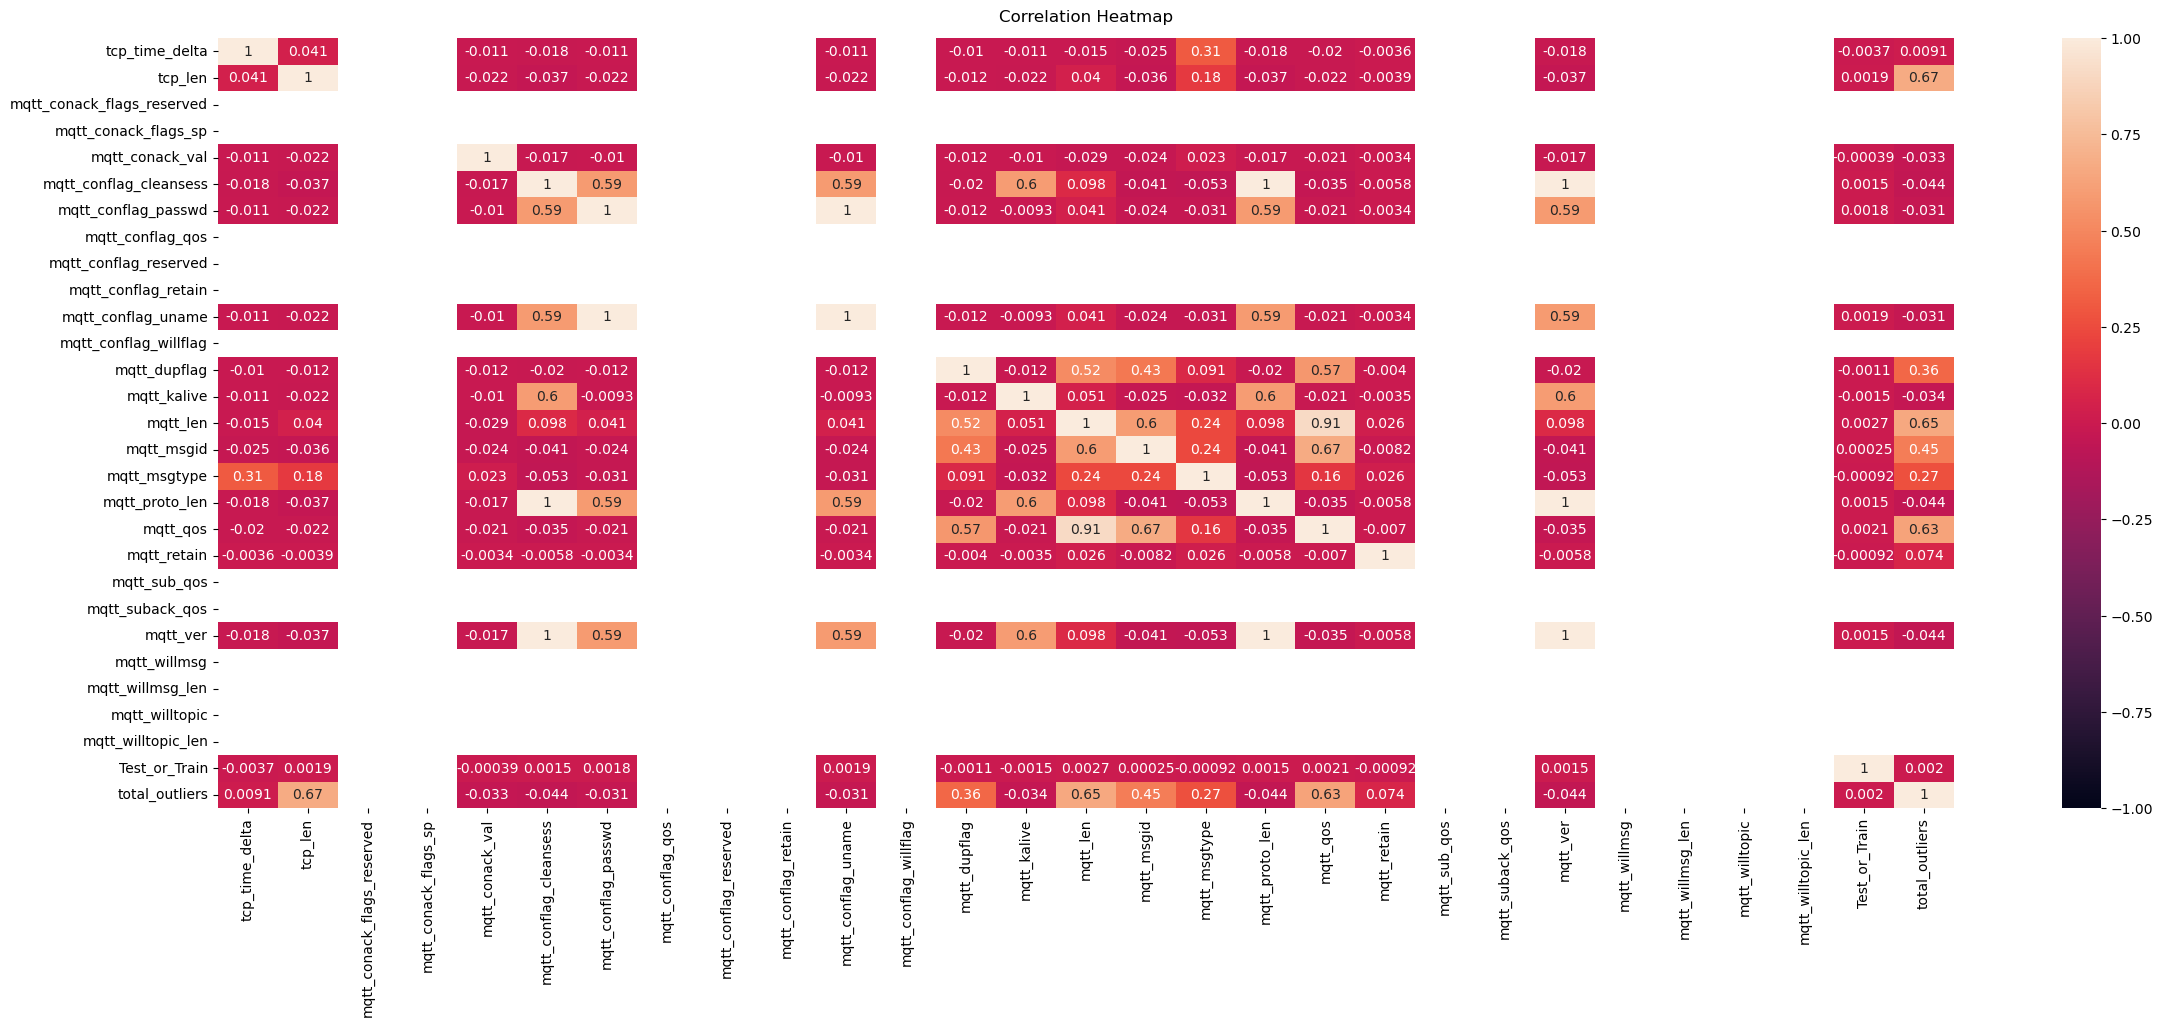

In [38]:
correlation_matrix = df_with_substituted_na_and_outliers.toPandas().corr()
# print(correlation_matrix)

plt.figure(figsize=(28, 10))
heatmap = sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [39]:
df_with_handled_correlations = df_with_substituted_na_and_outliers\
                .drop("mqtt_conflag_cleansess","mqtt_proto_len","mqtt_conflag_passwd",
                     "mqtt_qos")

Through inspection, it was found that eight of the numeric columns were very closely correlated, where the correlation index > 0.95. Out of these eight columns, four were dropped, namely mqtt_conflag_cleansess, mqtt_proto_len, mqtt_conflag_passwd and mqtt_qos.

### One-hot Encoding Categorical Columns

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline


# We don't have any ordinal variables. Only nominal variables
# first part : transform the columns to numeric
stage_1 = StringIndexer(inputCol= 'tcp_flags', outputCol= 'tcp_flags_index')
stage_2 = StringIndexer(inputCol= 'mqtt_conack_flags', outputCol= 'mqtt_conack_flags_index')
stage_3 = StringIndexer(inputCol= 'mqtt_conflags', outputCol= 'mqtt_conflags_index')
stage_4 = StringIndexer(inputCol= 'mqtt_hdrflags', outputCol= 'mqtt_hdrflags_index')
stage_5 = StringIndexer(inputCol= 'mqtt_msg', outputCol= 'mqtt_msg_index')
stage_6 = StringIndexer(inputCol= 'mqtt_protoname', outputCol= 'mqtt_protoname_index')
stage_7 = StringIndexer(inputCol= 'target', outputCol= 'target_index')

# second part : one-hot encode the numeric columns
stage_8= OneHotEncoder(inputCols=["tcp_flags_index","mqtt_conack_flags_index",
                                  "mqtt_conflags_index","mqtt_hdrflags_index", 
                                 'mqtt_msg_index', 'mqtt_protoname_index', 'target_index'], 
                        outputCols=["tcp_flags_encoded","mqtt_conack_flags_encoded",
                                  "mqtt_conflags_encoded","mqtt_hdrflags_encoded", 
                                 'mqtt_msg_encoded', 'mqtt_protoname_encoded', 'target_encoded'])

# setup the pipeline
pipeline = Pipeline(stages=[stage_1, stage_2, stage_3, stage_4, stage_5, stage_6, stage_7, stage_8])

# fit the pipeline model and transform the data as defined
pipeline_model = pipeline.fit(df_with_handled_correlations)
df_encoded = pipeline_model.transform(df_with_handled_correlations)

In [ ]:
print(df_encoded.select("target").distinct().count())
# In our NSL-KDD dataset, the length is 3. Now, let's view some examples
df_encoded.select("target","target_index","target_encoded")\
                .distinct().toPandas()

### Vector Assembly of Pipeline

In [ ]:
from pyspark.ml.feature import VectorAssembler
feature_list = df_encoded.drop("tcp_flags","tcp_flags_index","mqtt_conack_flags", "mqtt_conack_flags_index",
                                        "mqtt_conflags", "mqtt_conflags_index","mqtt_hdrflags", "mqtt_hdrflags_index",
                                        'mqtt_msg','mqtt_msg_index', 'mqtt_protoname', 'mqtt_protoname_index',
                               'target', 'target_index', "target_encoded").columns

vector_assembler = VectorAssembler(
    inputCols=feature_list, 
    outputCol="vectorized_features")

df_with_assembled_features = vector_assembler.transform(df_encoded)

### Datascaling

In [ ]:
from pyspark.ml.feature import StandardScaler

standard_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
scaled_model = standard_scaler.fit(df_with_assembled_features)
df_with_scaled_features = scaled_model.transform(df_with_assembled_features)

df_with_scaled_features.select("target","target_encoded","features").distinct().toPandas()